# Exercise project 3 – CNN for time series classification (Telemetry dataset)

For this exercise project I used the telemetry dataset with over 400,000 rows. It included two measurements: temperature and humidity, and I used the timestamp column to order the data. The code in the notebook was based on a Keras tutorial that I experimented with (you can find it in ex3 folder)

https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k

### Step 0: Importing libraries and loading the dataset

In [ ]:
import keras
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_3"
os.chdir(folder_path)

In [ ]:
df = pd.read_csv('data/telemetry.csv', usecols=['ts', 'humidity', 'temp'])
df = df.reset_index()

### Step 1: Data analysis and visualisations

In [ ]:
df.head()

,index,ts,humidity,temp
0,0,1.594512e+09,51.000000,22.700000
1,1,1.594512e+09,76.000000,19.700001
2,2,1.594512e+09,50.900000,22.600000
3,3,1.594512e+09,76.800003,27.000000
4,4,1.594512e+09,50.900000,22.600000


In [ ]:
print("NaN count:", (df.isna().sum()))

NaN count: sequence       0
class          0
measurement    0
dtype: int64


Here I converted the timestamp value to datetime

In [ ]:
df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values(by='ts', ascending=True)

In [ ]:
df.head(2)

,index,ts,humidity,temp
0,0,1970-01-01 00:00:01.594512094,51.0,22.700000
1,1,1970-01-01 00:00:01.594512094,76.0,19.700001


In [ ]:
df.describe()

,index,ts,humidity,temp
count,405184.000000,405184,405184.000000,405184.000000
mean,202591.500000,1970-01-01 00:00:01.594858016,60.511694,22.453987
min,0.000000,1970-01-01 00:00:01.594512094,1.100000,0.000000
25%,101295.750000,1970-01-01 00:00:01.594685999,51.000000,19.900000
50%,202591.500000,1970-01-01 00:00:01.594857988,54.900000,22.200000
75%,303887.250000,1970-01-01 00:00:01.595030576,74.300003,23.600000
max,405183.000000,1970-01-01 00:00:01.595203417,99.900002,30.600000
std,116966.690072,NaN,11.366489,2.698347


In [ ]:
df.head()

,index,ts,humidity,temp
0,0,1970-01-01 00:00:01.594512094,51.000000,22.700000
1,1,1970-01-01 00:00:01.594512094,76.000000,19.700001
2,2,1970-01-01 00:00:01.594512098,50.900000,22.600000
3,3,1970-01-01 00:00:01.594512099,76.800003,27.000000
4,4,1970-01-01 00:00:01.594512101,50.900000,22.600000


Then I scaled the humidity and temperature values using MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
num_cols = ["temp", "humidity"]
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
df["sequence"] = df.index + 1
df = df.drop(["ts", "index"], axis=1)

In [ ]:
df.describe()

,humidity,temp,sequence
count,405184.000000,405184.000000,405184.000000
mean,0.601333,0.733790,202592.500000
std,0.115045,0.088181,116966.690072
min,0.000000,0.000000,1.000000
25%,0.505061,0.650327,101296.750000
50%,0.544534,0.725490,202592.500000
75%,0.740891,0.771242,303888.250000
max,1.000000,1.000000,405184.000000


In [ ]:
df.tail()

,humidity,temp,sequence
405179,0.751012,0.627451,405180
405180,0.479757,0.725490,405181
405182,0.751012,0.627451,405183
405181,0.755061,0.869281,405182
405183,0.478745,0.725490,405184


### Step 2: Data pre-processing

I reshaped the data so each variable (temp and humidity) became its own class. I used pd.melt() to make sure that each row had just one measurement type and a class label:

In [ ]:
df = pd.melt(df, id_vars=["sequence"], value_vars=["temp", "humidity"],
             var_name="class", value_name="measurement")

In [ ]:
df.head()

,sequence,class,measurement
0,1,temp,0.741830
1,2,temp,0.643791
2,3,temp,0.738562
3,4,temp,0.882353
4,5,temp,0.738562


Now I had two classes, each with exactly 405,184 samples, which is very balanced.

In [ ]:
class_counts = df['class'].value_counts()
print("Instance per class:\n", class_counts)

Instance per class:
 class
temp        405184
humidity    405184
Name: count, dtype: int64


In [ ]:
df['class'] = df['class'].map({"temp": 0, "humidity": 1}).astype('int64')
print("Unique values in 'class' column:", df['class'].unique())

Unique values in 'class' column: [0 1]


In [ ]:
df.head(2)

,sequence,class,measurement
0,1,0,0.741830
1,2,0,0.643791


In [ ]:
class_names = np.array(["temp", "humidity"])
classes = list(range(len(class_names)))
num_classes = len(classes)

In [ ]:
df_class_1 = df[df['class'] == 0]
df_class_2 = df[df['class'] == 1]

splitted_dfs = [df_class_1, df_class_2]

In [ ]:
df_class_1['class'].value_counts()

,count
class,
0,405184


In [ ]:
df_class_2['class'].value_counts()

,count
class,
1,405184


In [ ]:
df

,sequence,class,measurement
0,1,0,0.741830
1,2,0,0.643791
2,3,0,0.738562
3,4,0,0.882353
4,5,0,0.738562
...,...,...,...
810363,405180,1,0.751012
810364,405181,1,0.479757
810365,405183,1,0.751012
810366,405182,1,0.755061


To prepare the data for the CNN, I split the long signal into chunks of 50 points, also called timesteps.I calculated in a way that the number of data points was divisible by 50, which gave me exactly 16,206 sequences

In [ ]:
sequence_max = df['sequence'].max()
print("Highest value divisible by 50:", sequence_max)

Highest value: 405184


In [ ]:
def make_divisible_by_50(number):
    remainder = number % 50
    adjusted_number = number - remainder
    return adjusted_number

sequence_50 = make_divisible_by_50(sequence_max)
print("Original number:", sequence_max)
print("Adjusted number:", sequence_50)

Original number: 405184
Adjusted number: 405150


In [ ]:
max_size = sequence_50
timestep_size = 50

x_total = []
y_total = []

for category in classes:
    index_cutoff = 0

    while index_cutoff / max_size < 1:
        timestep = []

        slice = splitted_dfs[category].iloc[index_cutoff:index_cutoff + timestep_size]

        x_total.append(list(slice['measurement']))
        y_total.append(category)

        index_cutoff += timestep_size

In [ ]:
x_total_count = len(x_total)
y_total_count = len(y_total)
print(x_total_count)
print(y_total_count)

16206
16206


In [ ]:
x_total[55]

array([0.64379087, 0.74183006, 0.64379087, 0.83006534, 0.74183006,
       0.83333332, 0.64379087, 0.74183006, 0.74183006, 0.74183006,
       0.83006534, 0.74509803, 0.74183006, 0.83006534, 0.74183006,
       0.64379087, 0.83006534, 0.74183006, 0.64379087, 0.74509803,
       0.83006534, 0.74183006, 0.64379087, 0.83006534, 0.74183006,
       0.83333332, 0.74183006, 0.64379087, 0.64379087, 0.74183006,
       0.83333332, 0.74183006, 0.64379087, 0.74183006, 0.64379087,
       0.74183006, 0.83006534, 0.74183006, 0.64379087, 0.74183006,
       0.83006534, 0.74183006, 0.64379087, 0.74183006, 0.83006534,
       0.64379087, 0.74183006, 0.74183006, 0.83006534, 0.64379087])

In [ ]:
y_total[55]

0

In [ ]:
print(x_total_count)
print(timestep_size)

16206
50


In [ ]:
timestep_size * x_total_count

810300

In [ ]:
import random
zipped = list(zip(x_total, y_total))
random.shuffle(zipped)
x_total, y_total = zip(*zipped)

In [ ]:
y_total[6]

0

In [ ]:
x_total = np.array(x_total)
y_total = np.array(y_total)
print(x_total.shape)
print(y_total.shape)

(16206, 50)
(16206,)


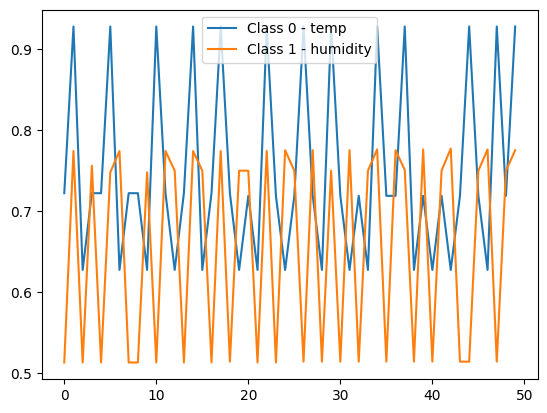

In [ ]:
test_signal_index = 2

c_x_train = x_total[y_total == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0 - temp")

c_x_train = x_total[y_total == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1 - humidity")
plt.legend()

In [ ]:
train_size = 0.7
splitter = int(len(x_total) * train_size)

# split by the index
x_train = x_total[0:splitter]
x_test = x_total[splitter:]
y_train = y_total[0:splitter]
y_test = y_total[splitter:]

In [ ]:
print(f"x_train: {len(x_train)}")
print(f"x_test: {len(x_test)}")
print(f"y_train: {len(y_train)}")
print(f"y_test: {len(y_test)}")

x_train: 11344
x_test: 4862
y_train: 11344
y_test: 4862


Then I reshaped the data into the shape the CNN expects: (samples, timesteps, 1), which for me was (11344, 50, 1) for training.

In [ ]:
x_train

array([[0.75607289, 0.49392712, 0.49291497, ..., 0.59615384, 0.75708502,
        0.49898785],
       [0.73856208, 0.73856208, 0.78104573, ..., 0.78104573, 0.73856208,
        0.64705879],
       [0.85620916, 0.748366  , 0.63725489, ..., 0.75163398, 0.85294118,
        0.75163398],
       ...,
       [0.82679735, 0.73529411, 0.64379087, ..., 0.83006534, 0.73529411,
        0.64379087],
       [0.80065358, 0.63071892, 0.72549019, ..., 0.63071892, 0.72549019,
        0.72549019],
       [0.73202613, 0.62091502, 0.72875816, ..., 0.72549019, 0.61764704,
        0.72549019]])

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_train

array([[[0.75607289],
        [0.49392712],
        [0.49291497],
        ...,
        [0.59615384],
        [0.75708502],
        [0.49898785]],

       [[0.73856208],
        [0.73856208],
        [0.78104573],
        ...,
        [0.78104573],
        [0.73856208],
        [0.64705879]],

       [[0.85620916],
        [0.748366  ],
        [0.63725489],
        ...,
        [0.75163398],
        [0.85294118],
        [0.75163398]],

       ...,

       [[0.82679735],
        [0.73529411],
        [0.64379087],
        ...,
        [0.83006534],
        [0.73529411],
        [0.64379087]],

       [[0.80065358],
        [0.63071892],
        [0.72549019],
        ...,
        [0.63071892],
        [0.72549019],
        [0.72549019]],

       [[0.73202613],
        [0.62091502],
        [0.72875816],
        ...,
        [0.72549019],
        [0.61764704],
        [0.72549019]]])

### Step 3: Model Architecture

In [ ]:
def make_model(input_shape):
    model = keras.Sequential(
        [
            keras.layers.Input(input_shape),

            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            keras.layers.Dense(64, activation="relu"),

            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

I trained it for 10 epochs, with early stopping and learning rate reduction set up to make sure it didn’t overfit.

In [ ]:
epochs = 10
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    TqdmCallback(verbose=1)
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=0
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### Step 4: Model Evaluation

The model trained really fast and well. It reached nearly perfect results

In [ ]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9112e-05 - sparse_categorical_accuracy: 1.0000
Test accuracy 0.9997943043708801
Test loss 0.0003586108796298504


In [ ]:
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


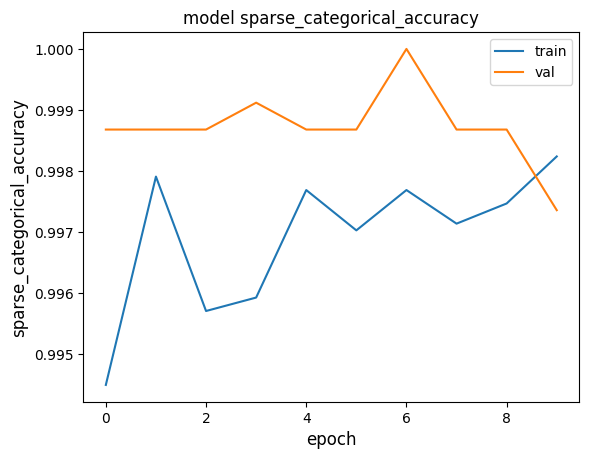

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
model.history = history
loss_df = pd.DataFrame(model.history.history)

In [ ]:
print(loss_df)

       loss  sparse_categorical_accuracy  val_loss  \
0  0.016836                     0.994490  0.004399   
1  0.007103                     0.997906  0.007970   
2  0.013938                     0.995703  0.001911   
3  0.011911                     0.995923  0.001300   
4  0.008594                     0.997686  0.004112   
5  0.009259                     0.997025  0.004774   
6  0.007371                     0.997686  0.007617   
7  0.010584                     0.997135  0.004649   
8  0.008029                     0.997466  0.002897   
9  0.005613                     0.998237  0.014250   

   val_sparse_categorical_accuracy  learning_rate  
0                         0.998678          0.001  
1                         0.998678          0.001  
2                         0.998678          0.001  
3                         0.999119          0.001  
4                         0.998678          0.001  
5                         0.998678          0.001  
6                         1.000000       

<Axes: >

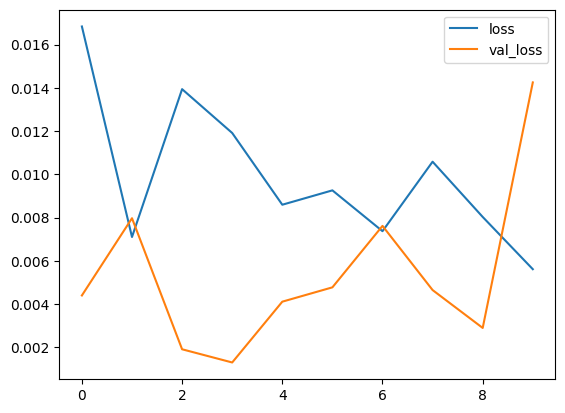

In [ ]:
loss_df[['loss', 'val_loss']].plot()

<Axes: >

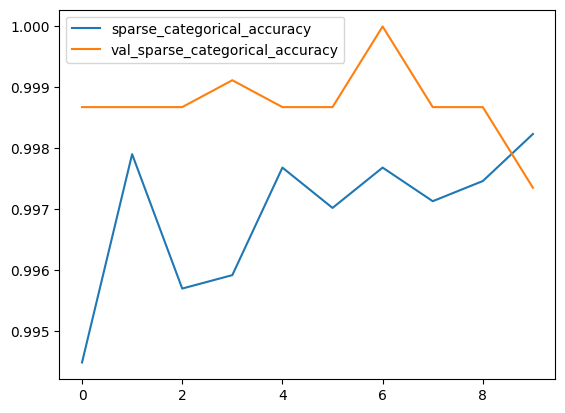

In [ ]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

<Axes: >

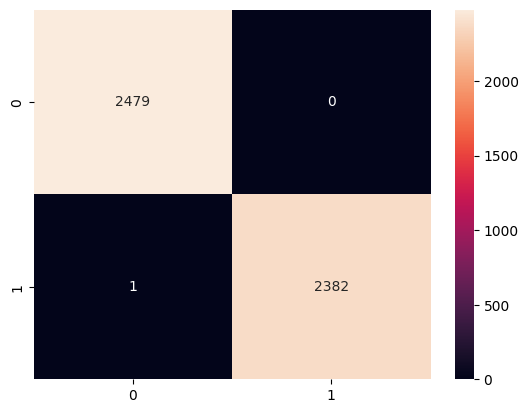

In [ ]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [ ]:
print(classification_report(y_test, test_predictions))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2479
           1       1.00      1.00      1.00      2383

    accuracy                           1.00      4862
   macro avg       1.00      1.00      1.00      4862
weighted avg       1.00      1.00      1.00      4862


Model overall accuracy: 99.98%


In [ ]:
# roc auc score also very good
roc_auc_score(y_test, model.predict(x_test)[:, 1])

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


1.0

### Step 5: Predictions

I wanted to see how the model behaves with single sequences. I tried predicting a few individual test signals and printed both the raw output and the predicted class. It was accurate every time.



In [ ]:
temperature_index = 3
humidity_index = 1

test_signal = np.expand_dims(x_test[humidity_index], axis=0)
result = model.predict(test_signal)
index = np.argmax(result)
print(result)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
[[9.9996936e-01 3.0663574e-05]]
temp


1
humidity


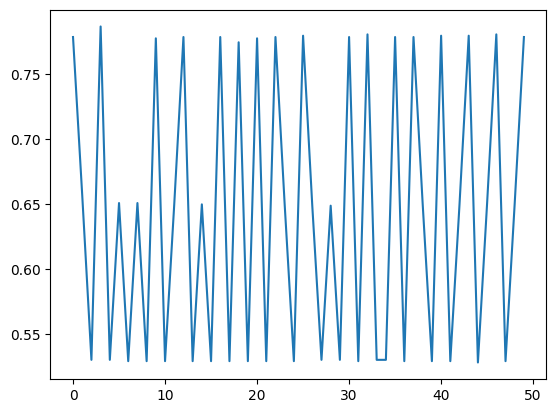

In [ ]:
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])
plt.figure()
plt.plot(x_test[signal_index])
plt.show()

0
temp


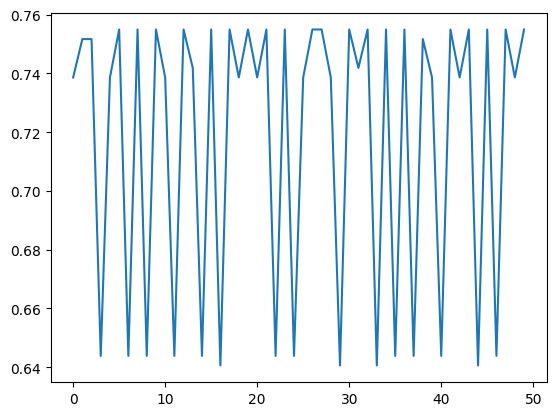

In [ ]:
signal_index = 12
print(y_test[signal_index])
print(class_names[y_test[signal_index]])
plt.figure()
plt.plot(x_test[signal_index])
plt.show()

<Axes: >

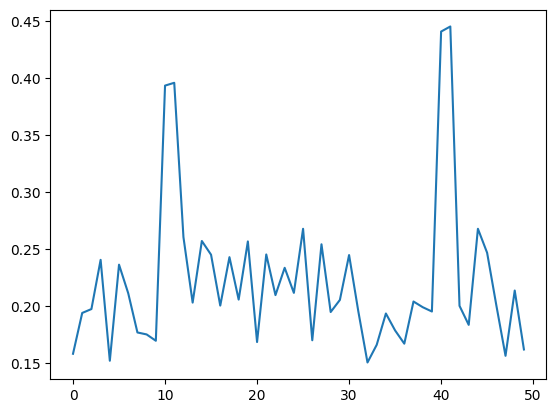

In [ ]:
x_values = np.arange(50)

y_values = np.random.uniform(0.15, 0.27, size=50)

y_values[10:12] = 0.45
y_values[40:42] = 0.45

y_values[10:12] += np.random.uniform(-0.075, 0.075, size=2)
y_values[40:42] -= np.random.uniform(-0.075, 0.075, size=2)

y_values = np.clip(y_values, 0, 1)

sns.lineplot(x=x_values, y=y_values)

### Personal Analysis / Refelection

One of the main challenges I faced was reshaping the telemetry data into a format that could work with a CNN. I had to learn how to convert a continuous time series into timesteps and label them correctly. Another tricky part was handling both temp and humidity as separate classes by melting the dataframe, which was a new method for me.

I also spent time figuring out how to structure the input as (samples, timesteps, 1) and balance the dataset. Luckily, the dataset had exactly the same number of samples for both classes, which made training smoother.


Even with only two classes and one feature per signal, the model achieved almost perfect results. The final accuracy was 99.98%, the ROC-AUC score was 1.0, and both classes had precision, recall, and F1-score of 1.00. The confusion matrix showed 1 misclassifications, which means the model learned the patterns very well and the validation loss stayed low and did not increase during training, so it did not overfit.

A real-world use case for this kind of classification could be in IoT or smart buildings, where temperature and humidity data are constantly monitored. A CNN could detect whether the incoming signal belongs to a "temperature-type" or "humidity-type" pattern, maybe.

Overall, this exercise helped me better understand how time series data can be used with CNNs.